In [1]:
import warnings
warnings.simplefilter(action ="ignore")
warnings.filterwarnings("ignore")

from collections import Counter

# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

In [2]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip show scikit-learn version

Name: scikit-learnNote: you may need to restart the kernel to use updated packages.

Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior writte

In [4]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')

In [5]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [7]:
print(f"The dataset size: {df.shape}")

The dataset size: (1014, 7)


In [8]:
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [9]:
df.tail()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


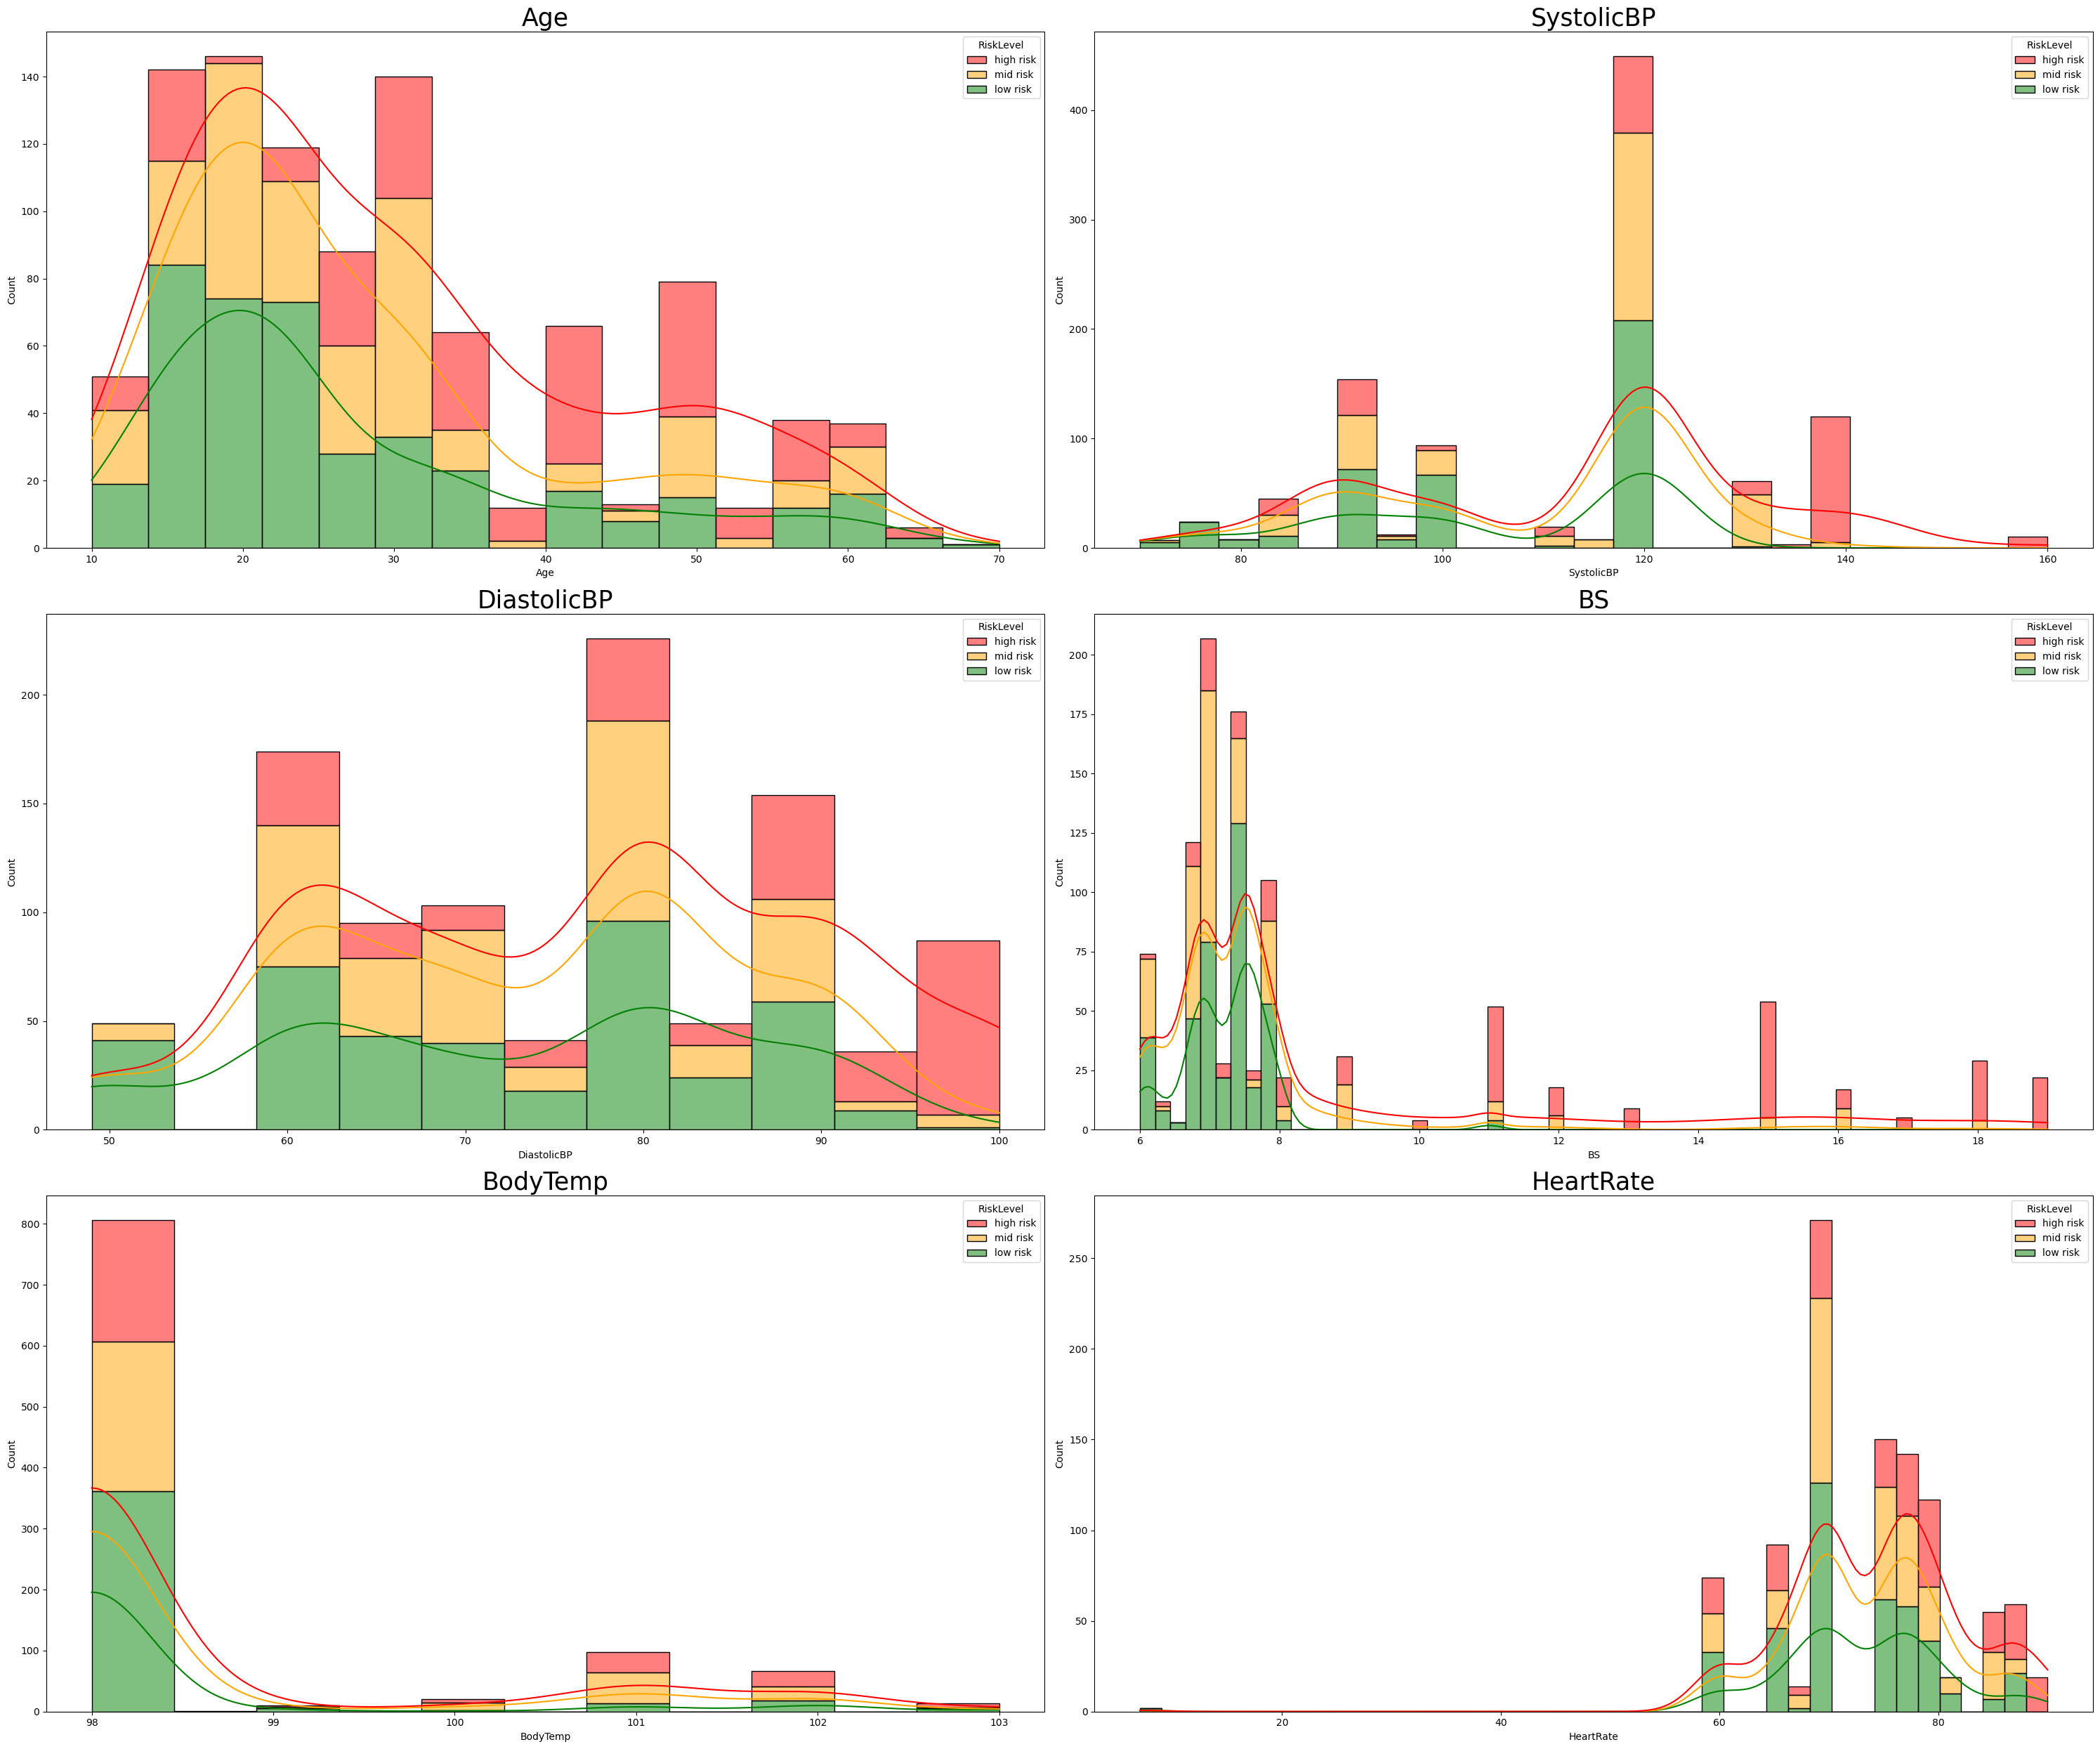

In [10]:
# Plot stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 25))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), df.columns):
    sns.histplot(data=df,
                 x=column,
                 kde=True,
                 hue="RiskLevel",
                 hue_order=risk_level_order,
                 multiple="stack",
                 palette={"low risk": "green", "mid risk": "orange", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=25)

plt.tight_layout()
plt.savefig("maternal_features_description.png")
plt.show()

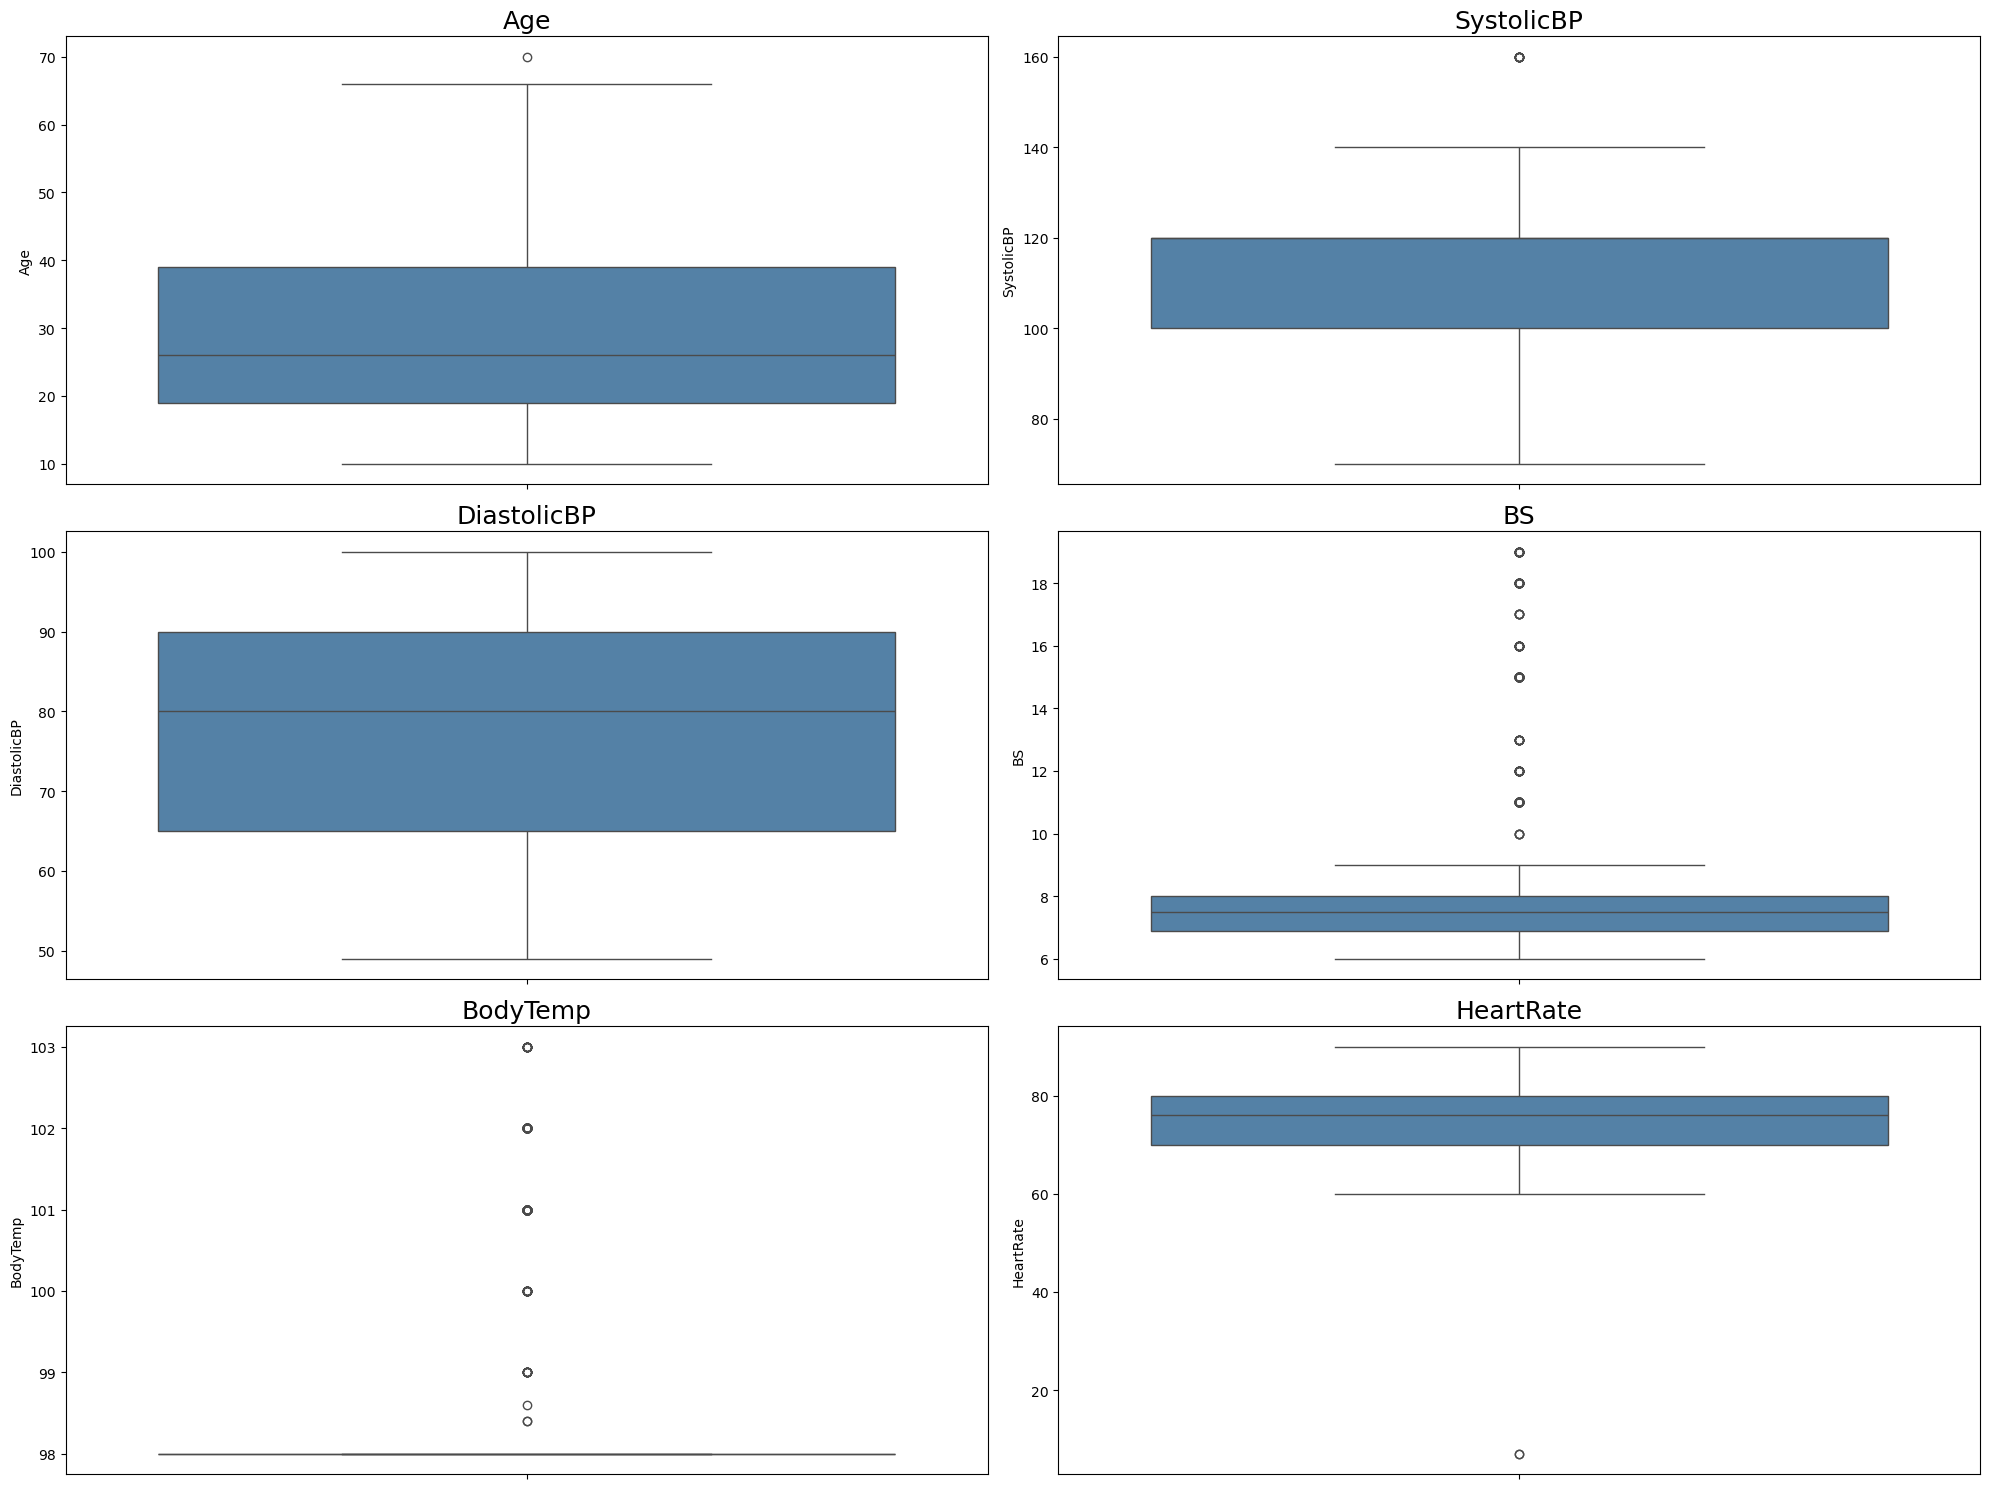

In [11]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df.columns):
    sns.boxplot(y=df[column],
                color="#4682B4",
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

In [12]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


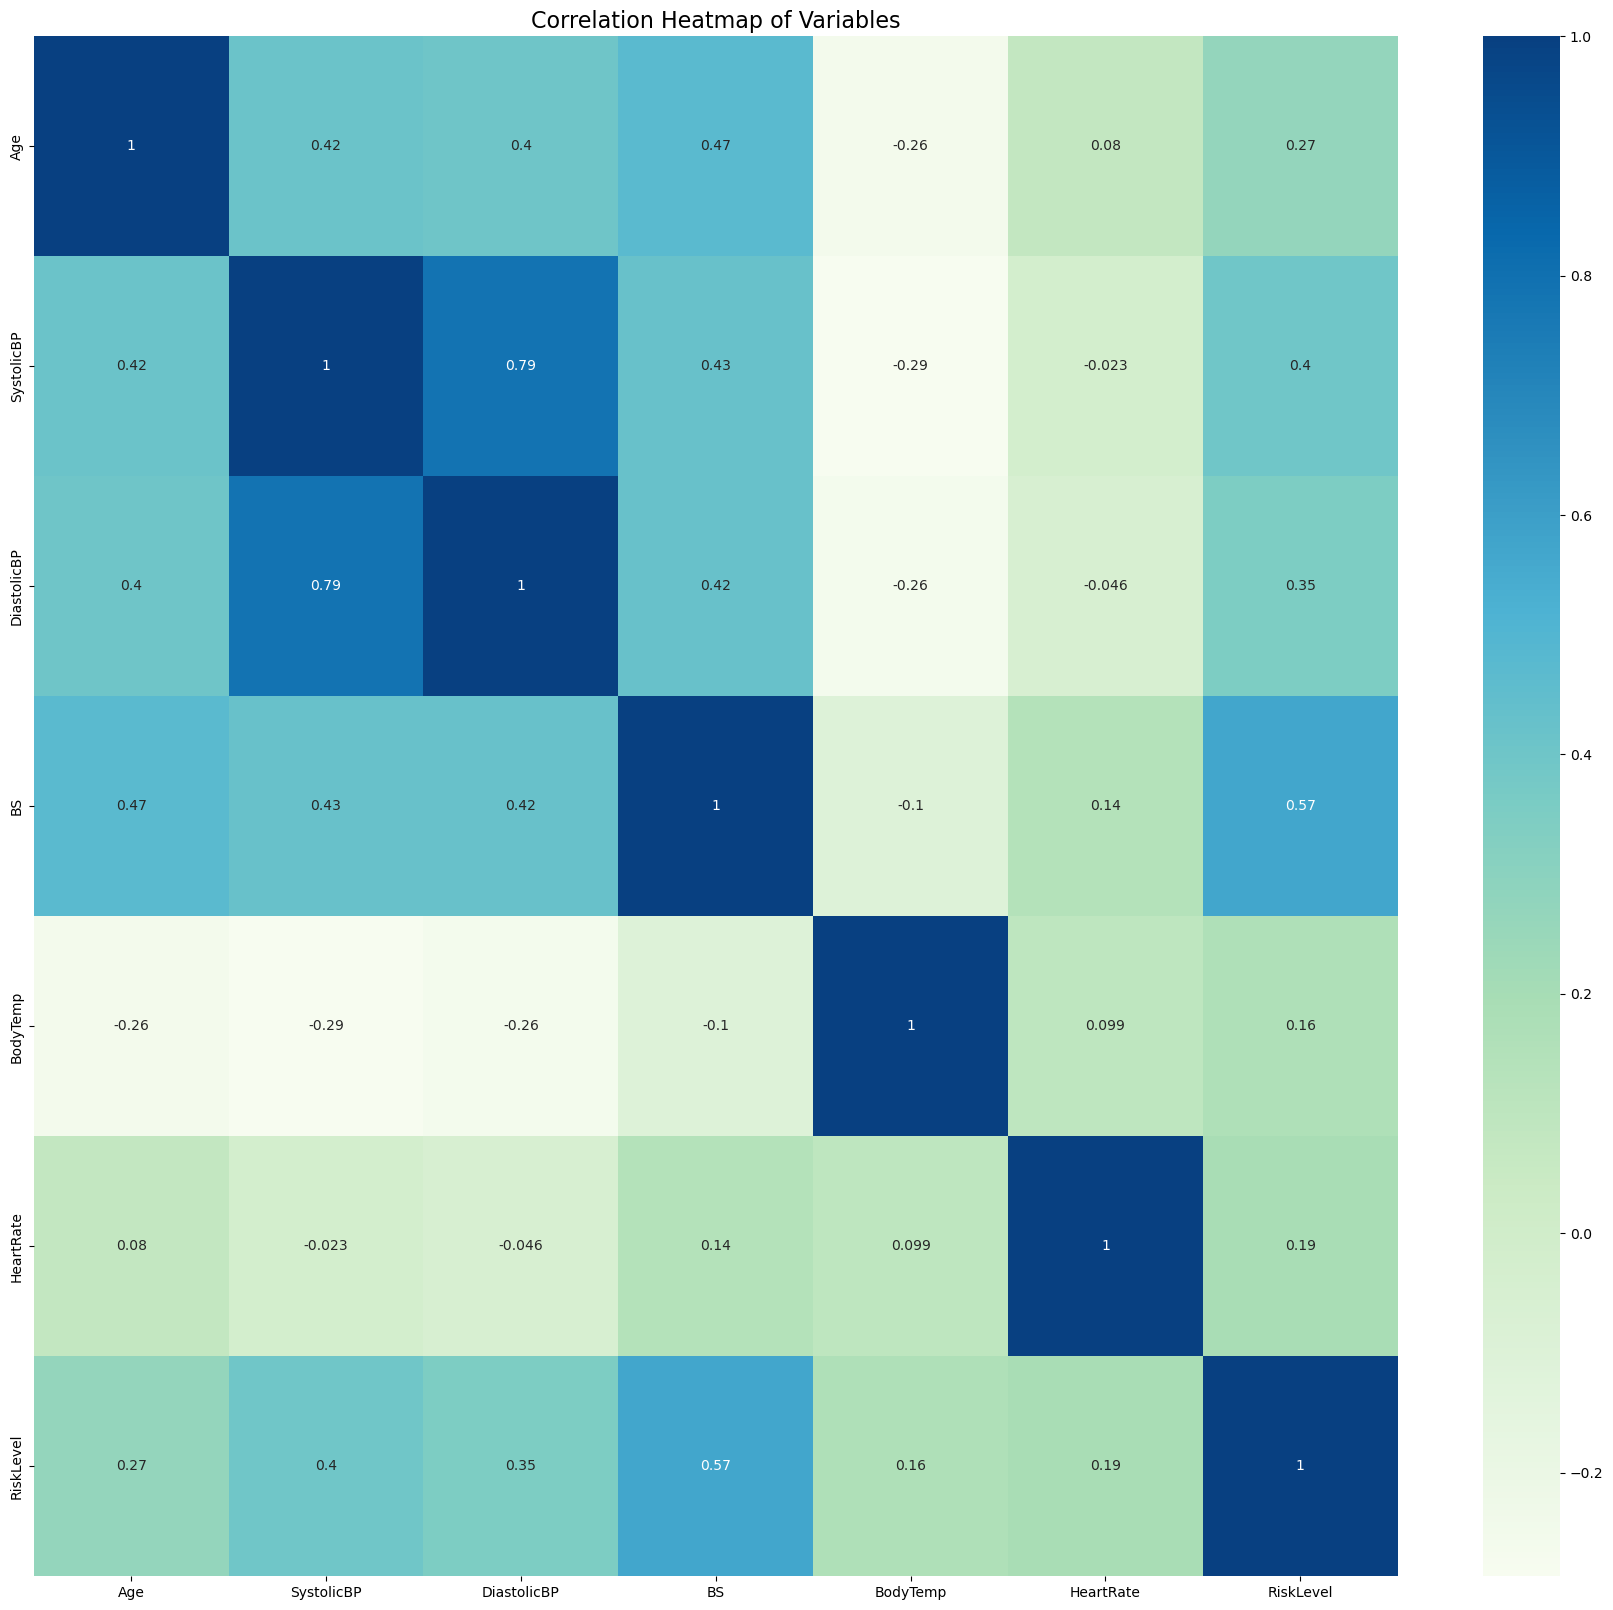

In [13]:
# Create a correlation heatmap
plt.figure(figsize=(22,20))
sns.heatmap(df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

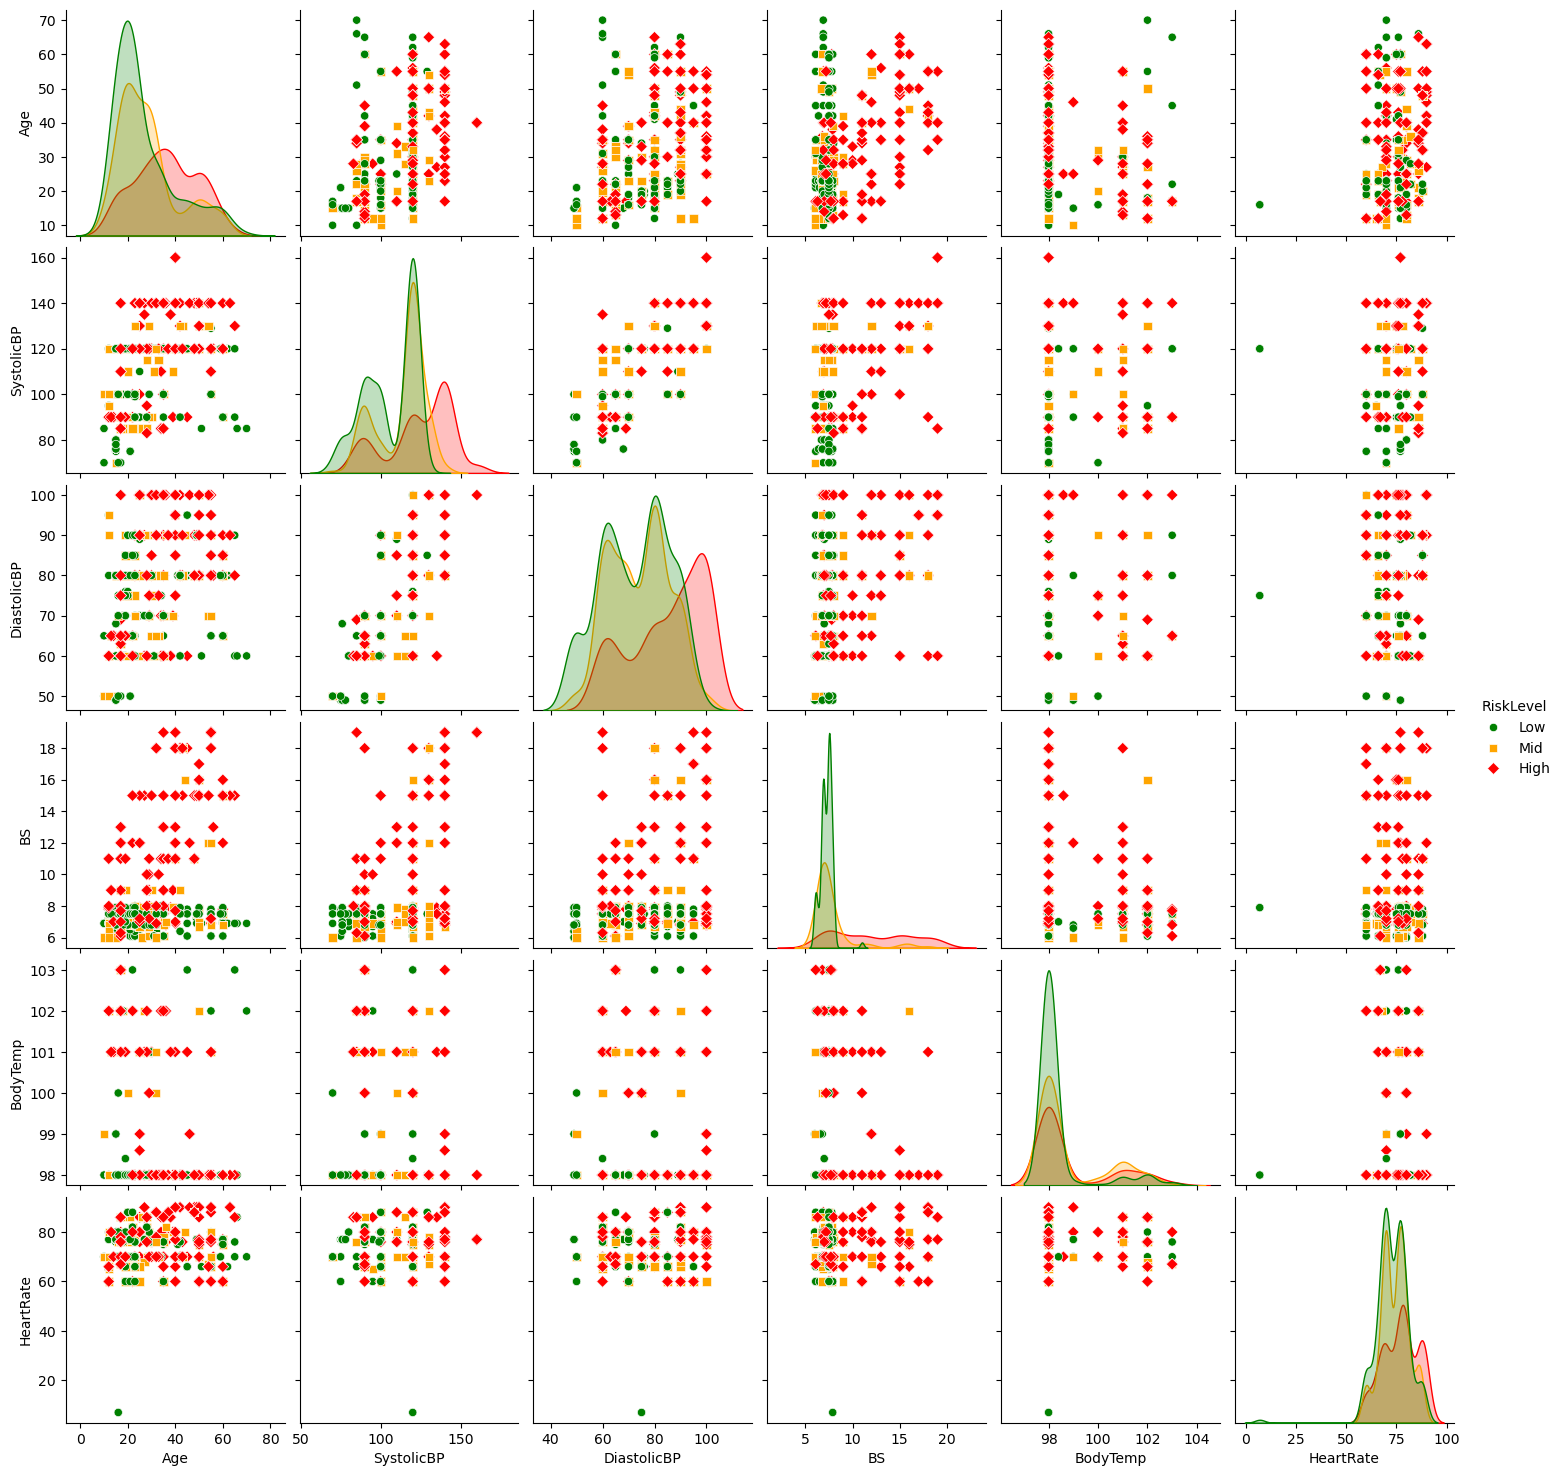

In [14]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(df, hue='RiskLevel',
                    palette=risk_colors,
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)
plt.savefig("maternal_pairplot_to_see_patterns.png")
plt.show()

In [15]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [16]:
# Drop SystolicBP for model training
df = df.drop(["SystolicBP"], axis=1)

In [17]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

908     7
499     7
702    60
783    60
784    60
Name: HeartRate, dtype: int64

In [18]:
# Remove the outlier in HeartRate
df = df.drop(df.index[df.HeartRate == 7])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


In [20]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = df["RiskLevel"] 

In [21]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


In [23]:
!pip install --upgrade imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


Original class distribution: Counter({0: 406, 1: 336, 2: 272})
Resampled class distribution: Counter({2: 406, 0: 406, 1: 406})


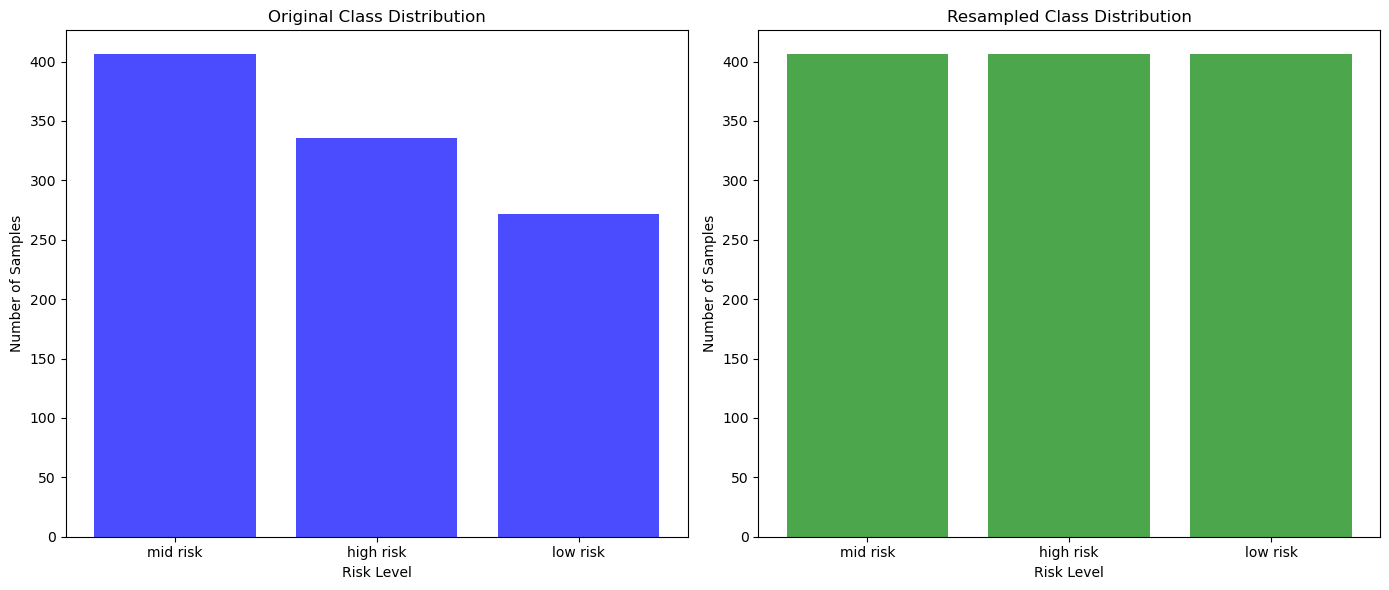

First few rows of resampled data:
   Age  DiastolicBP    BS  BodyTemp  HeartRate
0   25           80  15.0      98.0         86
1   35           90  13.0      98.0         70
2   29           70   8.0     100.0         80
3   30           85   7.0      98.0         70
4   35           60   6.1      98.0         76
0    high risk
1    high risk
2    high risk
3    high risk
4     low risk
dtype: object


In [25]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# Load your dataset (replace with your file path)
file_path = 'Maternal Health Risk Data Set.csv'
df = pd.read_csv('Maternal Health Risk Data Set.csv')

# Define feature columns and target column
feature_columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]  # Adjust as needed
target_column = "RiskLevel"

# Map target labels to numeric values
label_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df[target_column + '_numeric'] = df[target_column].map(label_mapping)

# Define feature matrix and target vector
X = df[feature_columns]
y = df[target_column + '_numeric']

# Print the original class distribution
original_distribution = Counter(y)
print("Original class distribution:", original_distribution)

# Determine the majority class size
majority_class_size = max(original_distribution.values())

# Define sampling strategy to balance all classes up to the majority class size
sampling_strategy = {cls: majority_class_size for cls in original_distribution}

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the resampled class distribution
resampled_distribution = Counter(y_resampled)
print("Resampled class distribution:", resampled_distribution)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot original distribution
ax[0].bar(original_distribution.keys(), original_distribution.values(), color='blue', alpha=0.7)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Risk Level')
ax[0].set_ylabel('Number of Samples')
ax[0].set_xticks(list(original_distribution.keys()))
ax[0].set_xticklabels(['low risk', 'mid risk', 'high risk'])

# Plot resampled distribution
ax[1].bar(resampled_distribution.keys(), resampled_distribution.values(), color='green', alpha=0.7)
ax[1].set_title('Resampled Class Distribution')
ax[1].set_xlabel('Risk Level')
ax[1].set_ylabel('Number of Samples')
ax[1].set_xticks(list(resampled_distribution.keys()))
ax[1].set_xticklabels(['low risk', 'mid risk', 'high risk'])

plt.tight_layout()
plt.show()

# Optionally, convert the numeric target back to original labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_resampled_labels = [reverse_label_mapping[x] for x in y_resampled]

# Print first few rows of resampled data
print("First few rows of resampled data:")
print(pd.DataFrame(X_resampled, columns=feature_columns).head())
print(pd.Series(y_resampled_labels).head())


In [27]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((811, 5), (203, 5), (811,), (203,))

In [29]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.67


In [31]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.59409594 0.61481481 0.68148148]
CrossValMeans: 0.63
CrossValStandard Deviation: 0.037


In [33]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [35]:
from sklearn.model_selection import RandomizedSearchCV

RandomizedSearchCV_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                            param_distributions=params_knn,
                                            n_iter=10, # Number of parameter settings that are sampled
                                            cv=3,
                                            scoring="accuracy",
                                            return_train_score=True
                                           )

In [37]:
# Fit model with train data
RandomizedSearchCV_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19,
                                                        20],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   return_train_score=True, scoring='accuracy')

In [39]:
print(f"Best estimator for KNN model:\n{RandomizedSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{RandomizedSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(RandomizedSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=27, n_neighbors=12, weights='distance')
Best parameter values:
{'weights': 'distance', 'p': 2, 'n_neighbors': 12, 'leaf_size': 27}
Best score for GNB model: 0.747


In [41]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [43]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.246
Root Mean Square Error for K_Nearest Neighbor = 0.496
R^2(coefficient of determination) on training set = 0.931
R^2(coefficient of determination) on testing set = 0.828


In [45]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        81
           1       0.77      0.79      0.78        67
           2       0.89      0.93      0.91        55

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203

Confusion Matrix:
[[64 16  1]
 [ 9 53  5]
 [ 4  0 51]]


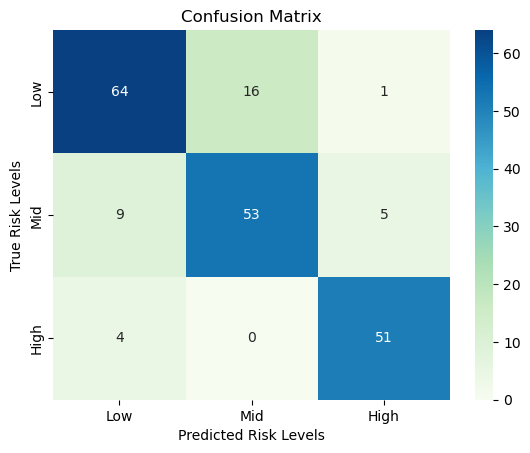

In [47]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

In [49]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

# Use accuracy_score for classification problems
from sklearn.metrics import accuracy_score # Import the appropriate metric

accuracy_knn = accuracy_score(y_test, pred_knn) # Calculate accuracy
print(f"Accuracy of KNN model: {accuracy_knn}")

score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

Accuracy of KNN model: 0.8275862068965517


In [51]:
# Create a DataFrame to easily handle missing values
results_df = pd.DataFrame({'y_test': y_test, 'pred_knn': pred_knn})

# Remove rows with NaN values
results_df = results_df.dropna()

# Update y_test and pred_knn with cleaned data
y_test_cleaned = results_df['y_test']
pred_knn_cleaned = results_df['pred_knn']

# Recompute the classification report and confusion matrix
print("Classification Report")
print(classification_report(y_test_cleaned, pred_knn_cleaned))
print("Confusion Matrix:")
print(confusion_matrix(y_test_cleaned, pred_knn_cleaned))

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        81
           1       0.77      0.79      0.78        67
           2       0.89      0.93      0.91        55

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203

Confusion Matrix:
[[64 16  1]
 [ 9 53  5]
 [ 4  0 51]]


In [53]:
# RandomizedSearchCV for KNN hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_neighbors': np.arange(1, 31),  # Tune the number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=20, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and print them
print(f'Best parameters found: {random_search.best_params_}')

# Use the best estimator for further predictions
best_knn = random_search.best_estimator_


Best parameters found: {'weights': 'uniform', 'p': 1, 'n_neighbors': 1}


In [55]:
# Perform cross-validation using the SMOTE-balanced data
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=10, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores)}')

Cross-Validation Accuracy: 0.7940379403794038


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np

# Step 1: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_distributions, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Best model after tuning
best_knn = random_search.best_estimator_

# Step 3: Evaluate performance on train and test set
train_score = cross_val_score(best_knn, X_train_scaled, y_train, cv=10).mean()
test_score = best_knn.score(X_test_scaled, y_test)

# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["K-Nearest Neighbors"],
    "Train Score": [train_score],
    "Test Score": [test_score]
})

# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, best_knn.predict(X_test_scaled), average="weighted")[metrics.index(metric)]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df

,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.847291,K-Nearest Neighbors,0.792849,0.850415,0.847291,0.847741


In [59]:
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load your dataset
data = pd.read_csv('Maternal Health Risk Data Set.csv')

# Features (X) and Target (y)
X = data[['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = data['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})  # Encoding the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, y_train)

# Save the trained model using joblib
joblib.dump(model, 'KNeighborsClassifier.pkl')

# Save the scaler as well, so you can use it in the app for scaling inputs
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [61]:
pip show joblib version

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: C:\ProgramData\anaconda3\Lib\site-packages
Requires: 
Required-by: imbalanced-learn, nltk, scikit-learn
Note: you may need to restart the kernel to use updated packages.
